In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, linalg as sla
from math import pi
import magnetic_boundaries as mb

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

In [2]:
parameters = {
    'width' : 50, # This is in units of 3a
    'bottom_bearded' : True,
    'top_bearded' : False,
    'mag_field' : 0.005,
    'noise' : 0,
    'seed' : 0
             }
#Calculate bands
momenta, bands = mb.graphene_bands(parameters, npoints = 501)

Text(0.5, 0, '$k_x\\,(a)$')

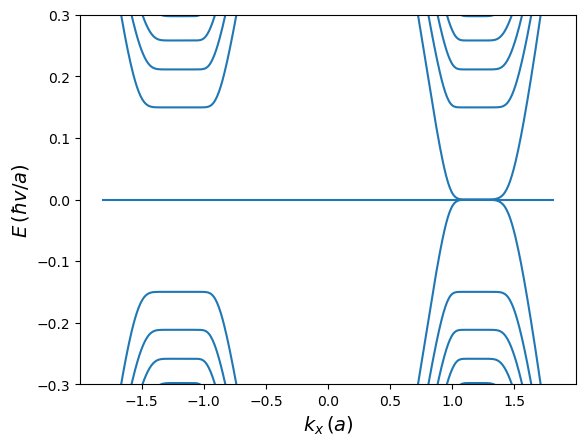

In [3]:
#Plot bands
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(bands.shape[1]):
    ax.plot(momenta,bands[:,i], c = 'C0')

ax.set_ylim(-0.3,0.3)
#ax.set_xlim(-pi/np.sqrt(3),-0.5)
ax.set_ylabel(r'$E\,(\hbar v/a)$',fontsize = 14)
ax.set_xlabel(r'$k_x\,(a)$',fontsize = 14)

In [8]:
def graphene_bands(parameters,npoints):
    '''
    Finds the spectrum of a graphene nanoribbon
    with zigzag boundary conditions
    in a uniform magnetic field.
    In this case the units are given by a = 1 (y = 3a), hbar = 1, e = 1, v_F = 1
    -parameters: dict
    -npoints: int number of points calculated
    Returns
    -momenta: numpy array of size npoints
    -bands: numpy matrix of size 4*width-2+bottom_bearded+top_bearded, npoints
    '''
    bands = []
    momenta = np.linspace(-pi/np.sqrt(3)/parameters['length'],pi/np.sqrt(3)/parameters['length'],npoints)
    for kx in momenta:
        parameters['kx'] = kx
        hamiltonian = graphene_square(parameters)
        spectrum = np.linalg.eigvalsh(hamiltonian)
        bands.append(spectrum)
        #bands.append(spectrum[np.argsort(np.abs(spectrum))]) #Sorted by distance to E=0
    bands = np.array(bands)

    return momenta, bands


def graphene_square(parameters):
    '''
    Returns the Hamiltonian for a square
    geometry in a magnetic field.
    In this case the units are given by a = 1 (y = 3a), hbar = 1, e = 1, v_F = 1
    -parameters: dict
    Returns
    -H: numpy matrix of size 4*width-2+bottom_bearded+top_bearded
    '''
    #The parameters dictionary must have the following key,value pairs
    length = parameters['length']     #int Number of lattice unit cells in x direction. Each cell contains 4 sites and it is sqrt(3)a long in x
    width = parameters['width']       #int Number of lattice unit cells in y direction. Each cell contains 4 sites and it is 3a long in y
    kx = parameters['kx']*np.sqrt(3)             # float in (-pi/pi] wavenumber in x direction. The sqrt(3) is because the x-direction lattice site is sqrt(3)a long.
                                                 # This war parameters['k_x'] has units of 1/a
    bottom_bearded = parameters['bottom_bearded'] #bool type of zigzag bc at the bottom
    top_bearded = parameters['top_bearded']       #bool type of zigzag bc at the top
    mag_field = parameters['mag_field']           #float magnetic field
    noise = parameters['noise']       #int disorder strength
    
    np.random.seed(parameters['seed']) #Set the seed before building the matrix
    peierls_factor = np.sqrt(3)/2*mag_field*3 #The 3 is because the y-direction lattice site is 3a long

    hamiltonian = np.zeros(((4*width-2+bottom_bearded+top_bearded)*length,(4*width-2+bottom_bearded+top_bearded)*length),dtype = complex)

    def index(orbital,y,x):
        return orbital + 4*y-1+bottom_bearded + (width*4-2+bottom_bearded+top_bearded)*x
        
    ### We have 4 orbitals
    for x in range(length):
        for y in range(width):
            if y!=0 or bottom_bearded:
                hamiltonian[index(0,y,x),index(1,y,x)] += -1
                hamiltonian[index(1,y,x),index(0,y,x)] += -1
            
            random_contribution = noise*(np.random.rand(1)[0]-0.5)
            hamiltonian[index(1,y,x),index(2,y,x)] += -np.exp(1j*peierls_factor*(y-width/2))*np.exp(1j*random_contribution)
            hamiltonian[index(2,y,x),index(1,y,x)] += -np.exp(-1j*peierls_factor*(y-width/2))*np.exp(-1j*random_contribution)
            hamiltonian[index(1,y,x),index(2,y,(x-1)%length)] += -np.exp(-1j*peierls_factor*(y-width/2))*np.exp(-1j*kx*length*(1 if x==0 else 0))
            hamiltonian[index(2,y,(x-1)%length),index(1,y,x)] += -np.exp(1j*peierls_factor*(y-width/2))*np.exp(1j*kx*length*(1 if x==0 else 0))
            
    
            if y!=width-1 or top_bearded:
                hamiltonian[index(2,y,x),index(3,y,x)] += -1
                hamiltonian[index(3,y,x),index(2,y,x)] += -1
    
            if y!=width-1:
                random_contribution = noise*(np.random.rand(1)[0]-0.5)
                hamiltonian[index(3,y,x),index(0,y+1,x)] += -np.exp(-1j*peierls_factor*(y+0.5-width/2))*np.exp(1j*random_contribution)
                hamiltonian[index(0,y+1,x),index(3,y,x)] += -np.exp(1j*peierls_factor*(y+0.5-width/2))*np.exp(-1j*random_contribution)
                hamiltonian[index(3,y,x),index(0,y+1,(x+1)%length)] += -np.exp(1j*peierls_factor*(y+0.5-width/2))*np.exp(1j*kx*length*(1 if x==length-1 else 0))
                hamiltonian[index(0,y+1,(x+1)%length),index(3,y,x)] += -np.exp(-1j*peierls_factor*(y+0.5-width/2))*np.exp(-1j*kx*length*(1 if x==length-1 else 0))

    return hamiltonian*2/3 #Adjusting units so that the fermi velocity is equal to 1

In [ ]:
parameters = {
    'width' : 50, # This is in units of 3a
    'length' : 3,
    'bottom_bearded' : True,
    'top_bearded' : False,
    'mag_field' : 0.005,
    'noise' : 0,
    'seed' : 0
             }

momenta, bands = graphene_bands(parameters, npoints = 501)

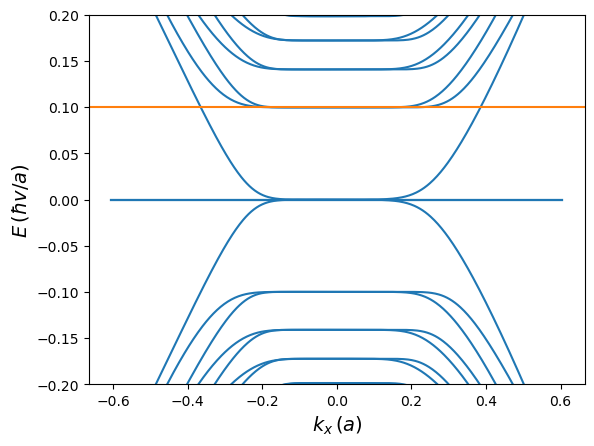

In [17]:
#Plot bands
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(bands.shape[1]):
    ax.plot(momenta,bands[:,i], c = 'C0')

ax.set_ylim(-0.2,0.2)
#ax.set_xlim(-pi/np.sqrt(3),-0.5)
ax.set_ylabel(r'$E\,(\hbar v/a)$',fontsize = 14)
ax.set_xlabel(r'$k_x\,(a)$',fontsize = 14)
ax.axhline(np.sqrt(2*parameters['mag_field']), c = 'C1')########################################################  First Landau level


(-0.2, 0.2)

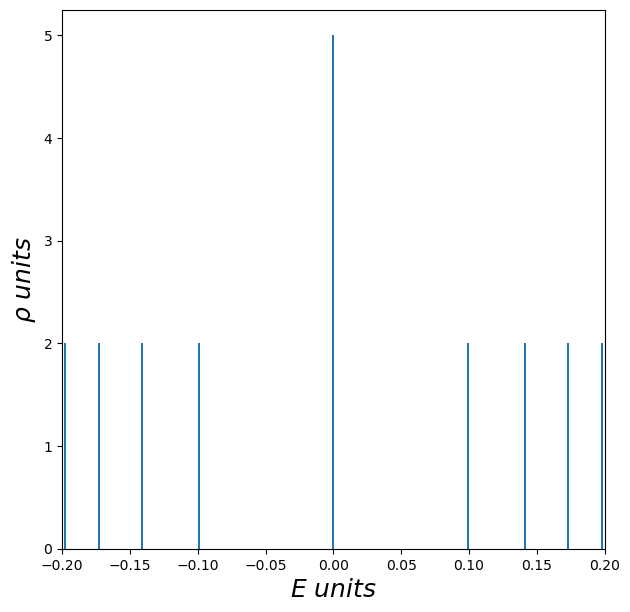

In [14]:
parameters = {
    'width' : 50, # This is in units of 3a
    'length' : 3,
    'bottom_bearded' : True,
    'top_bearded' : False,
    'mag_field' : 0.005,
    'noise' : 0,
    'seed' : 0
             }
#Calculate spectrum
spectrum = graphene_spectrum(parameters)

nbins = 2661
density_of_states, bin_edges = np.histogram(spectrum, bins = nbins, density = False)

x = (bin_edges[1:]+bin_edges[:-1])/2
dx = (bin_edges[1]-bin_edges[0])/2

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.bar(x,density_of_states,width = 2*dx)
ax.set_ylabel(r"$\rho$ $units$",fontsize = 18)
ax.set_xlabel(r"$E$ $units$",fontsize = 18)
ax.set_xlim(-0.2,0.2)

In [13]:
def graphene_spectrum(parameters):
    '''
    Finds the spectrum of a graphene square
    with zigzag boundary conditions in x direction
    and open in y direction
    in a uniform magnetic field.
    The units are given by a = 1 (y = 3a), hbar = 1, e = 1, v_F = 1
    -parameters: dict
    Returns
    -spectrum: numpy matrix of size (4*width-2+bottom_bearded+top_bearded)*length
    '''
    parameters['kx'] = 0
    hamiltonian = graphene_square(parameters)
    spectrum = np.linalg.eigvalsh(hamiltonian)

    return spectrum